In [1]:
import numpy
import anndata
import os
import pandas
import scipy
import scanpy
import upsetplot
from matplotlib import pyplot

In [2]:
%matplotlib inline

In [3]:
analysis_dir = 'ENCSR874BOF_e10_5_limb'

## Load data into scanpy

In [4]:
cellr_analysis_dir = os.path.join(analysis_dir, 'ENCSR874BOF-10x-e10_5-count-cells10000', 'outs')
cellr = scanpy.read_10x_mtx(
    os.path.join(cellr_analysis_dir, 'filtered_feature_bc_matrix'),
    var_names='gene_ids'
)
cellr

AnnData object with n_obs × n_vars = 7203 × 81881 
    var: 'gene_symbols', 'feature_types'

In [5]:
cellr.var_keys()

['gene_symbols', 'feature_types']

In [6]:
solo_analysis_dir = os.path.join(analysis_dir, 'diane_star_solo', 'Solo.out', 'Gene', 'filtered')
solo = scanpy.read_mtx(os.path.join(solo_analysis_dir, 'matrix.mtx')).T
solo_vars = pandas.read_csv(os.path.join(solo_analysis_dir, 'features.tsv'), header=None, sep='\t').values.T
solo_obs = pandas.read_csv(os.path.join(solo_analysis_dir, 'barcodes.tsv'), header=None, sep='\t').values.T
solo.obs_names = solo_obs[0]
# to use gene names load the id to name map
#alevin.var_names = [gene_id_name[x] for x in alevin_cols[0]]
solo.var_names = solo_vars[0]
#alevin_cols.shape, alevin_rows.shape
solo

AnnData object with n_obs × n_vars = 6287 × 81881 

In [7]:
solo.var_names

Index(['896', '897', '1275', '1914', '1915', '1916', '1917', '1918', '1919',
       '1920',
       ...
       'gSpikein_ERCC-00158', 'gSpikein_ERCC-00160', 'gSpikein_ERCC-00162',
       'gSpikein_ERCC-00163', 'gSpikein_ERCC-00164', 'gSpikein_ERCC-00165',
       'gSpikein_ERCC-00168', 'gSpikein_ERCC-00170', 'gSpikein_ERCC-00171',
       'gSpikein_phiX174'],
      dtype='object', length=81881)

In [8]:
solo

AnnData object with n_obs × n_vars = 6287 × 81881 

In [9]:
alevin_analysis_dir = os.path.join(analysis_dir, 'alevin_output_encode_R1_R2', 'alevin')
alevin = scanpy.read_mtx(os.path.join(alevin_analysis_dir, 'quants_mat.mtx.gz'))
alevin_vars = pandas.read_csv(os.path.join(alevin_analysis_dir, 'quants_mat_cols.txt'), header=None).values.T
alevin_obs = pandas.read_csv(os.path.join(alevin_analysis_dir, 'quants_mat_rows.txt'), header=None).values.T
alevin.obs_names = alevin_obs[0]
# to use gene names load the id to name map
#alevin.var_names = [gene_id_name[x] for x in alevin_cols[0]]
alevin.var_names = alevin_vars[0]
#alevin_cols.shape, alevin_rows.shape
alevin

AnnData object with n_obs × n_vars = 7302 × 72301 

In [10]:
kallisto_analysis_dir = os.path.join(analysis_dir, 'kallisto', 'genecount')
kallisto = scanpy.read_mtx(os.path.join(kallisto_analysis_dir, 'gene.mtx'))
kallisto_vars = pandas.read_csv(os.path.join(kallisto_analysis_dir, 'gene.genes.txt'), header=None).values.T
kallisto_obs = pandas.read_csv(os.path.join(kallisto_analysis_dir, 'gene.barcodes.txt'), header=None).values.T
kallisto.obs_names = kallisto_obs[0]
# to use gene names load the id to name map
#alevin.var_names = [gene_id_name[x] for x in alevin_cols[0]]
kallisto.var_names = kallisto_vars[0]
#alevin_cols.shape, alevin_rows.shape
kallisto

AnnData object with n_obs × n_vars = 584570 × 81881 

In [11]:
kallisto_em_analysis_dir = os.path.join(analysis_dir, 'kallisto_em', 'genecount')
kallisto_em = scanpy.read_mtx(os.path.join(kallisto_em_analysis_dir, 'gene.mtx'))
kallisto_em_vars = pandas.read_csv(os.path.join(kallisto_em_analysis_dir, 'gene.genes.txt'), header=None).values.T
kallisto_em_obs = pandas.read_csv(os.path.join(kallisto_em_analysis_dir, 'gene.barcodes.txt'), header=None).values.T
kallisto_em.obs_names = kallisto_em_obs[0]
# to use gene names load the id to name map
kallisto_em.var_names = kallisto_em_vars[0]
kallisto_em

AnnData object with n_obs × n_vars = 584570 × 81881 

# Basic checks

## Check that the annotation set is comptable

Alevin's matrix is noticably smaller than the the others (72,301 annotations vs 81,881)

In [12]:
len(set(solo.var_names).difference(alevin.var_names))

9580

Grab a few names so we can try to see what's going on

In [13]:
list(set(solo.var_names).difference(alevin.var_names))[:20]

['2705',
 '25377',
 '7904',
 '2670',
 '6926',
 '38898',
 '34304',
 '45914',
 '6909',
 '71046',
 '51358',
 '43460',
 '2769',
 'ENSMUSG00000100678.1',
 '38360',
 '7370',
 '37214',
 '46497',
 'ENSMUSG00000094007.1',
 'ENSMUSG00000101185.1']

I have a hunch Alevin isn't writing the all zeros rows.

In [14]:
numpy.all(solo.obs_vector('ENSMUSG00000102026.1') == 0)

True

In [15]:
alevin_zeros_vars =  set(solo.var_names).difference(alevin.var_names)
alevin_all_zeros = 0
for name in alevin_zeros_vars:
    if numpy.all(solo.obs_vector(name) != 0):
        print(name, solo.obs_vector(name))
    else:
        alevin_all_zeros += 1
print(f'{alevin_all_zeros} entries were all zero')


9580 entries were all zero


If we add in the all zeros, do we get the same number of feature annotations?

In [16]:
len(set(cellr.var_names).intersection(alevin.var_names)) + alevin_all_zeros == len(cellr.var_names)

True

We need our matricies to have the same shape for analysis, so we need to add those zeros back in.

Is one of the gene names from the all zero set in the list of annotations?

In [17]:
'ENSMUSG00000096558.1' in alevin.var_names

False

Compute new matrix index with the missing names added in

In [18]:
alevin_var_names_extended = pandas.DataFrame(index=alevin.var_names.values.tolist() + list(alevin_zeros_vars))
alevin_var_names_extended

""
897
1914
1915
1918
1919
...
46222
37712
50741
33279


Is the missing ID now found in the extended matrix?

In [19]:
'ENSMUSG00000096558.1' in alevin_var_names_extended

False

In [20]:
alevin.n_obs

7302

Generate new full size matrix

In [21]:
alevin.X.resize((alevin.n_obs, solo.n_vars))

In [22]:
alevin_full = anndata.AnnData(alevin.X, obs=alevin.obs, var=alevin_var_names_extended)

Is the missing ID in the new matrix?

In [23]:
'ENSMUSG00000096558.1' in alevin_full.var_names

True

Now we need to adjust the order of the annotations to match everyone else

In [24]:
alevin_full_new_var_index, alevin_full_new_var_order = alevin_full.var.index.reindex(solo.var.index)

In [25]:
alevin_full.X = alevin_full.X[:,alevin_full_new_var_order]
alevin_full.var = pandas.DataFrame(index=alevin_full_new_var_index)

Did we scramble the feature index compared to the data values?

In [26]:
features_to_check = numpy.random.choice(solo.var_names, size=100, replace=False)

In [27]:
feature_misses = 0
for f in features_to_check:
    if f in alevin.var_names:
        assert numpy.all(alevin_full.obs_vector(f) == alevin.obs_vector(f))
    else:
        assert numpy.all(alevin_full.obs_vector(f) == 0)
        feature_misses += 1
print(f'{feature_misses} were from the all zero set' )        

15 were from the all zero set


### Check that gene lists are the same

In [28]:
all(cellr.var_names==solo.var_names)

True

In [29]:
all(cellr.var_names==kallisto.var_names)

True

In [30]:
all(cellr.var_names==alevin_full.var_names)

True

Is the list of common annotations plus the missing all zero rows equal to the full annotation set of 81,881?

### Do barcodes share the same format?

In [31]:
print(cellr.obs.head())
print(solo.obs.head())
print(alevin_full.obs.head())
print(kallisto.obs.head())
print(kallisto_em.obs.head())

Empty DataFrame
Columns: []
Index: [AAACCTGAGAGTCGGT-1, AAACCTGAGTCGTACT-1, AAACCTGAGTGGTCCC-1, AAACCTGCAATGGACG-1, AAACCTGCACAGTCGC-1]
Empty DataFrame
Columns: []
Index: [AAACCTGAGTCGTACT, AAACCTGAGTGGTCCC, AAACCTGCAATGGACG, AAACCTGCAGCTGTTA, AAACCTGCAGTCAGCC]
Empty DataFrame
Columns: []
Index: [GCAGTTAGTCCAGTTA, TCTGGAATCAGGTTCA, GTGTTAGGTACTCGCG, CACTCCACATGCAATC, CCCAGTTTCGTTTGCC]
Empty DataFrame
Columns: []
Index: [AAACCTGAGAAACCAT, AAACCTGAGAAACCGC, AAACCTGAGAAACCTA, AAACCTGAGAAACGAG, AAACCTGAGAAACGCC]
Empty DataFrame
Columns: []
Index: [AAACCTGAGAAACCAT, AAACCTGAGAAACCGC, AAACCTGAGAAACCTA, AAACCTGAGAAACGAG, AAACCTGAGAAACGCC]


No, cell ranger leaves the -1 on it.

### Fix cellranger IDs

In [32]:
cellr.obs=pandas.DataFrame(index=pandas.Index([x[:16] for x in list(cellr.obs.index)]))

In [33]:
cellr.obs.index

Index(['AAACCTGAGAGTCGGT', 'AAACCTGAGTCGTACT', 'AAACCTGAGTGGTCCC',
       'AAACCTGCAATGGACG', 'AAACCTGCACAGTCGC', 'AAACCTGCAGCTGTTA',
       'AAACCTGCAGTCAGCC', 'AAACCTGCATCCCATC', 'AAACCTGGTCCGAAGA',
       'AAACCTGGTGTGAAAT',
       ...
       'TTTGTCACATCCCACT', 'TTTGTCAGTAATCACC', 'TTTGTCAGTATGAAAC',
       'TTTGTCAGTGTGACCC', 'TTTGTCAGTGTGGTTT', 'TTTGTCATCACTTCAT',
       'TTTGTCATCCGGCACA', 'TTTGTCATCGCGCCAA', 'TTTGTCATCGGAGGTA',
       'TTTGTCATCGTTACGA'],
      dtype='object', length=7203)

# How similar are the barcodes

In [34]:
print('Cell ranger filtered', len(cellr.obs.index))
print('STAR Solo filtered', len(solo.obs.index))
print('Alevin', len(alevin_full.obs.index))
print('Kallisto gene', len(kallisto.obs.index))
print('Kallisto em gene', len(kallisto_em.obs.index))

Cell ranger filtered 7203
STAR Solo filtered 6287
Alevin 7302
Kallisto gene 584570
Kallisto em gene 584570


Looks like Kallisto doesn't output a filtered set by default.

## Build a comparable pass filter common barcode set

Is the star solo set a proper subset of the other three?

In [35]:
len(set(solo.obs.index).intersection(cellr.obs.index))

6287

In [36]:
len(set(solo.obs.index).intersection(alevin_full.obs.index))

6287

In [37]:
len(set(solo.obs.index).intersection(kallisto.obs.index))

6287

Yes.

How about is the cell ranger set a proper subset of the alevin set?

In [38]:
len(set(cellr.obs.index).intersection(alevin_full.obs.index))

6843

Well nope they picked different marginal cells

Generate upset plot comparing the intersections of the filtered barcode sets. There's no need to include kallisto right now as they're only outputing the unfiltered matrix.

In [39]:
upset_contents = upsetplot.from_contents({
    'cellranger': cellr.obs.index,
    'star solo': solo.obs.index,
    'alevin': alevin_full.obs.index,
})

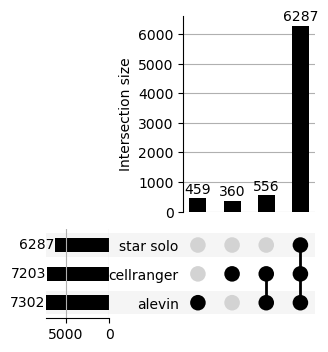

In [40]:
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_contents, fig=f, show_counts=True)

### Compute common bar code set

In [41]:
common_barcodes = set(cellr.obs.index).intersection(set(solo.obs.index))


# Filter matrices to common barcode set

In [42]:
def common_matrix(matrix, barcodes):
    new_obs_names, new_index = matrix.obs_names.reindex(barcodes)
    barcode_is_common = [x in common_barcodes for x in matrix.obs.index]
    common = matrix[new_index,:]
    common.obs_names = new_obs_names
    return common

In [43]:
def diff_matrix(matrix, barcodes):
    barcode_is_not_common = [x not in barcodes for x in matrix.obs.index]
    diff = matrix[barcode_is_not_common,:]
    return diff

In [44]:
cellr_common = common_matrix(cellr, common_barcodes)
cellr_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols', 'feature_types'

In [45]:
# This should be a null-op
solo_common = common_matrix(solo, common_barcodes)
solo_common

AnnData object with n_obs × n_vars = 6287 × 81881 

In [46]:
alevin_common = common_matrix(alevin_full, common_barcodes)
alevin_common

AnnData object with n_obs × n_vars = 6287 × 81881 

In [47]:
kallisto_common = common_matrix(kallisto, common_barcodes)
kallisto_common

AnnData object with n_obs × n_vars = 6287 × 81881 

In [48]:
kallisto_em_common = common_matrix(kallisto_em, common_barcodes)
kallisto_em_common

AnnData object with n_obs × n_vars = 6287 × 81881 

## Are the barcode columns in the same order?

In [49]:
assert numpy.all(cellr_common.obs_names == solo_common.obs_names)

In [50]:
assert numpy.all(cellr_common.obs_names == alevin_common.obs_names)

In [51]:
assert numpy.all(cellr_common.obs_names == kallisto_common.obs_names)

In [52]:
assert numpy.all(cellr_common.obs_names == kallisto_em_common.obs_names)

## Are the gene ids in the same order?

In [53]:
assert numpy.all(cellr_common.var_names == solo_common.var_names)
assert numpy.all(cellr_common.var_names == alevin_common.var_names)
assert numpy.all(cellr_common.var_names == kallisto_common.var_names)
assert numpy.all(cellr_common.var_names == kallisto_em_common.var_names)

## Collect method specific filtered unique cells.

Ignoring kallisto until we actualy have a filter.

In [54]:
cellr_diff = diff_matrix(cellr, common_barcodes)
cellr_diff

View of AnnData object with n_obs × n_vars = 916 × 81881 
    var: 'gene_symbols', 'feature_types'

In [55]:
solo_diff = diff_matrix(solo, common_barcodes)
solo_diff

View of AnnData object with n_obs × n_vars = 0 × 81881 

In [56]:
alevin_diff = diff_matrix(alevin_full, common_barcodes)
alevin_diff

View of AnnData object with n_obs × n_vars = 1015 × 81881 

## Make sure gene symbols are attached

Since everything is in the same order, we can just copy it from cell ranger.

In [57]:
solo_common.var['gene_symbols'] = cellr_common.var['gene_symbols']

In [58]:
alevin_common.var['gene_symbols'] = cellr_common.var['gene_symbols']
alevin_diff.var['gene_symbols'] = cellr_common.var['gene_symbols']

Trying to set attribute `.var` of view, copying.


In [59]:
kallisto_common.var['gene_symbols'] = cellr_common.var['gene_symbols']

In [60]:
kallisto_em_common.var['gene_symbols'] = cellr_common.var['gene_symbols']

## Is there spike expression?

This is summing along the spike rows, 

In [61]:
cellr_common[:, cellr_common.var_names.str.startswith('gSpike')].X.sum(axis=0)

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., 11.]], dtype=float32)

In [62]:
solo_common[:, solo_common.var_names.str.startswith('gSpike')].X.sum(axis=0)

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., 25.]], dtype=float32)

In [63]:
alevin_common[:, alevin_common.var_names.str.startswith("gSpike")].X.sum(axis=0)

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., 14.]], dtype=float32)

In [64]:
kallisto_common[:, kallisto_common.var_names.str.startswith("gSpike")].X.sum(axis=0)

matrix([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., 68.,  3.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., 40.]], dtype=float32)

In [65]:
kallisto_em_common[:, kallisto_em_common.var_names.str.startswith("gSpike")].X.sum(axis=0)

matrix([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., 68.,  3.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., 40.]], dtype=float32)

## Drop spike-ins (Disabled)

In [66]:
#cellr = cellr[:, numpy.invert(cellr.var_names.str.startswith("gSpike"))]
#cellr

In [67]:
#solo = solo[:, numpy.invert(solo.var_names.str.startswith("gSpike"))]
#solo

In [68]:
#alevin = alevin[:, numpy.invert(alevin.var_names.str.startswith("gSpike"))]
#alevin

# Save the cellranger detected barcode set

In [69]:
common_path = os.path.join(analysis_dir, 'common_barcodes.txt')
if not os.path.exists(common_path):
    with open(common_path, 'wt') as outstream:
        for barcode in common_barcodes:
            outstream.write(f'{barcode}\n')

# Save cached AnnData matricies

In [70]:
cellr_common.write(os.path.join(analysis_dir, "cellranger_filtered.sparse.h5ad"))
solo_common.write(os.path.join(analysis_dir, "solo_filtered.sparse.h5ad"))
alevin_common.write(os.path.join(analysis_dir, 'alevin_filtered.h5ad'))
kallisto_common.write(os.path.join(analysis_dir, 'kallisto_filtered.h5ad'))
kallisto_em_common.write(os.path.join(analysis_dir, 'kallisto_em_filtered.h5ad'))

... storing 'gene_symbols' as categorical
... storing 'feature_types' as categorical
... storing 'gene_symbols' as categorical
... storing 'gene_symbols' as categorical
... storing 'gene_symbols' as categorical
... storing 'gene_symbols' as categorical


In [71]:
cellr_diff.write(os.path.join(analysis_dir, "cellranger_diff_filtered.sparse.h5ad"))
alevin_diff.write(os.path.join(analysis_dir, 'alevin_diff_filtered.h5ad'))


/usr/lib/python3/dist-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'gene_symbols' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
... storing 'gene_symbols' as categorical
